In [1]:
# Example code to reproduce figure 1 in the paper 

# Use needs to update the API key, otherwise random embeddings will be generated

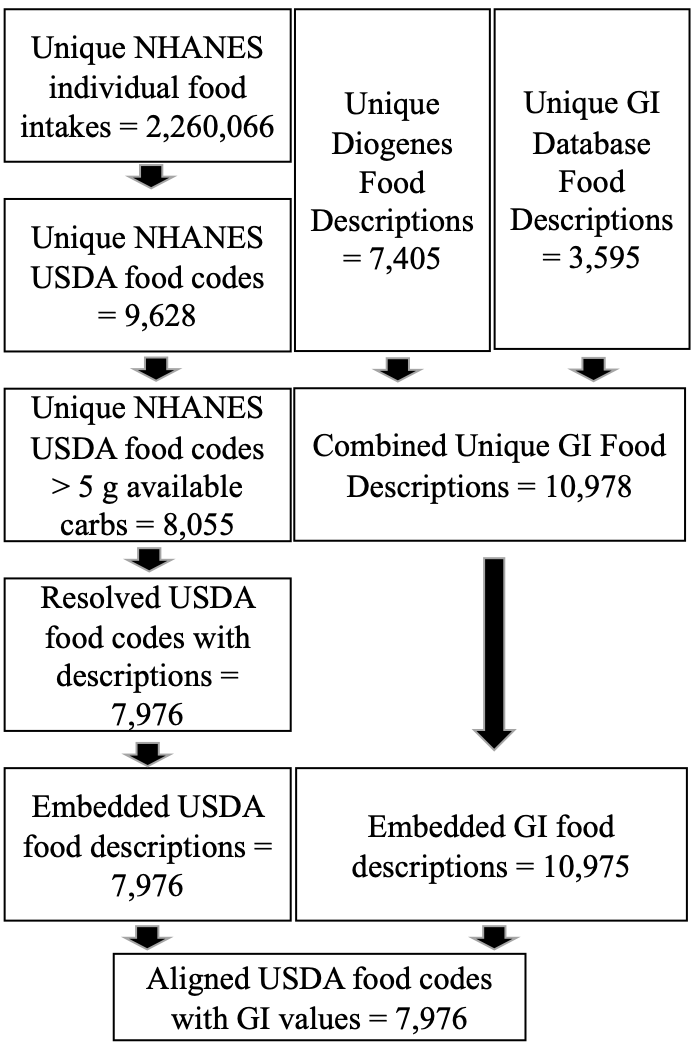

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import requests

def get_embedding(text_to_embed):
    openai_api_key = 'ADD OPENAI API Key here'

    if openai_api_key == 'ADD OPENAI API Key here':
        #print("No API key was provided")
        return np.random.rand(1536) 

    url = "https://api.openai.com/v1/embeddings"

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_api_key}"
    }

    payload = {
        "input": text_to_embed,
        "model": "text-embedding-ada-002"
    }

    response = requests.post(url, headers=headers, json=payload)

    if response.status_code == 200:
        embedded_string = response.json()
        return embedded_string['data'][0]['embedding']
    else:
        return []
    
import re

def delete_content_inside_parentheses(input_string):
    # Define a regular expression pattern to match content inside parentheses
    pattern = r"\([^)]*\)"
    
    # Use re.sub to replace the matched pattern with an empty string
    result_string = re.sub(pattern, '', input_string)
    
    return result_string

In [3]:
#NHANES
#1. Load all NHANES food codes
NHANES_food_codes = pd.read_csv('../data/NHANES_foodnames_availcarbs.csv')
print("Total food codes", NHANES_food_codes.shape[0])

#2. Subset all unique codes and amount of available carbs
NHANES_food_codes_unique = NHANES_food_codes.drop_duplicates(subset=['USDA food code'])
print("Unique food codes", NHANES_food_codes_unique.shape[0])

#3. Select all unique codes that have at least once available carbs > 5g
NHANES_food_codes_max = NHANES_food_codes.groupby('USDA food code').max().reset_index()
NHANES_food_codes_unique = NHANES_food_codes_max.drop_duplicates(subset=['USDA food code'])
NHANES_food_codes_unique_greater5g = NHANES_food_codes_unique[NHANES_food_codes_unique['available_carbs'] > 5]
print("Food codes with >5 g available carbs", NHANES_food_codes_unique_greater5g.shape[0])

#4. Resolve the food description for each code
with open("../data/code2food_publication.pkl", "rb") as file:
    foodcodes_nhanes_df = pkl.load(file)
NHANES_food_codes_unique_greater5g['Food Descriptions'] = NHANES_food_codes_unique_greater5g['USDA food code'].map(foodcodes_nhanes_df)
NHANES_food_codes_unique_greater5g = NHANES_food_codes_unique_greater5g[NHANES_food_codes_unique_greater5g['Food Descriptions'] != ""]
print("Number of resolved food codes", NHANES_food_codes_unique_greater5g.shape[0])

#5. Embed the codes
nhanes_embeddings_simple = {}

for string in NHANES_food_codes_unique_greater5g['Food Descriptions']:
    if string not in nhanes_embeddings_simple and not pd.isna(string):
        stripped_string = delete_content_inside_parentheses(string)
        embed_string = stripped_string.split(',')
        if len(embed_string) > 2:
            embed_string = ', '.join(embed_string[0:2])
        nhanes_embeddings_simple[string] = get_embedding(embed_string)

#GI Database
#1. Load Diogenes food names and GI values
gi_diagones_df = pd.read_json('../data/gi_full.json')
print('Unique Diogenes Food descriptions', gi_diagones_df['English translation'].unique().shape)

#2. Load GI DB food names and GI values
gi_sydney_df = pd.read_excel('../data/gi_db_sydney.xlsx')
print('Unique GI DB Food descriptions', gi_sydney_df['GI Description'].unique().shape)

#3. Merge the two databases 
all_simple_food_descriptions = {}
for string in gi_diagones_df['English translation'].to_list():
    stripped_string = delete_content_inside_parentheses(string)
    embed_string = stripped_string.split(',')
    if len(embed_string) > 2:
        embed_string = ', '.join(embed_string[0:2])
    all_simple_food_descriptions[string] = []

for string in gi_sydney_df['GI Description'].to_list():
    stripped_string = delete_content_inside_parentheses(string)
    embed_string = stripped_string.split(',')
    if len(embed_string) > 2:
        embed_string = ', '.join(embed_string[0:2])
    all_simple_food_descriptions[string] = []
print('Total strings', len(all_simple_food_descriptions))

#4. Embed the food names
gi_embeddings_simple = {}

for string in all_simple_food_descriptions:
    if string not in gi_embeddings_simple and not pd.isna(string):
        stripped_string = delete_content_inside_parentheses(string)
        embed_string = stripped_string.split(',')
        if len(embed_string) > 2:
            embed_string = ', '.join(embed_string[0:2])
        gi_embeddings_simple[string] = get_embedding(embed_string)

#Alignment process
#1. Calculate the similarity matrix between the two databases
food_em_arrays = [ np.array(em) for em in nhanes_embeddings_simple.values()]
gi_em_arrays = [ np.array(em) for em in gi_embeddings_simple.values()]
list1 = np.array(food_em_arrays)  # Convert list1 to a NumPy array
list2 = np.array(gi_em_arrays)  # Convert list2 to a NumPy array
list1_normalized = list1 / np.linalg.norm(list1, axis=1, keepdims=True)
list2_normalized = list2 / np.linalg.norm(list2, axis=1, keepdims=True)

cosine_similarity_matrix_simple = np.dot(list1_normalized, list2_normalized.T)

#2. Extract the most likely assignments
USDA2GIDB_simple = {}

indices = np.argmax(cosine_similarity_matrix_simple, axis=1)
maxima = np.max(cosine_similarity_matrix_simple, axis=1)
gi_keys = list(gi_embeddings_simple.keys())
for i, key in enumerate(nhanes_embeddings_simple):
    USDA2GIDB_simple[key] = [gi_keys[indices[i]],maxima[i]]

#3. Write out the aligned file for manual curation
df_out = pd.DataFrame(USDA2GIDB_simple).T
df_out = df_out.reset_index()
df_out.columns = ['USDA Food Name', 'GI DB Food name', 'Similarity Score']
df_out.to_csv('../results/example_alignment_for_manual_curation.csv', index=False)

Total food codes 2260067
Unique food codes 9628
Food codes with >5 g available carbs 8055
Number of resolved food codes 7976


/var/folders/w4/_tnmx6g51gs172glpm0xl8l00000gr/T/ipykernel_74802/3245869957.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NHANES_food_codes_unique_greater5g['Food Descriptions'] = NHANES_food_codes_unique_greater5g['USDA food code'].map(foodcodes_nhanes_df)


Unique Diogenes Food descriptions (7405,)
Unique GI DB Food descriptions (3595,)
Total strings 10978
